In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Warp simulations of space-charge neutralized electron beam

In [2]:
%matplotlib notebook

In [3]:
import sys
import numpy as np
import h5py as h5
import pickle

from rswarp.utilities import beam_analysis
from rswarp.utilities import file_utils
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import linregress
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/interpolate/_bs

In [5]:
from scipy.constants import c, physical_constants, m_e, e
m_e_ev = physical_constants['electron mass energy equivalent in MeV'][0]
m_e_kg = m_e

In [6]:
from cycler import cycler
colors = ["xkcd:windows blue", "xkcd:amber", "xkcd:faded green", 
          "xkcd:dusty purple", "xkcd:blood orange", "xkcd:bluish grey", 
          "xkcd:carmine", "xkcd:greenish blue", "xkcd:wine",
          "xkcd:spruce"]

# Functions
Useful functions for this notebook

In [7]:
# energy calculations
def p_to_beta(p, m=m_e_ev):
    # Assumes p in MeV/c
    p = p / (m * c)
    return p / np.sqrt(1 + p**2)
def p_to_ke(p, m=m_e_ev):
    # assumes p in MeV/c
    # returns KE in MeV
    beta = p_to_beta(p)
    gamma = 1 / np.sqrt(1 - beta**2)
    return m * gamma - m

# plotting routines
def map_colorbar(n, *args):
    n = len(full.keys())
    color = plt.cm.viridis_r(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))
    
    for axis in args:
        axis.set_prop_cycle('color', hexcolor)

def create_colorbar(vmin, vmax, axis, bbox_to_anchor=(1.01, 0.25, 1, 1)):
    axins = inset_axes(axis,
                       width="5%",  # width = 10% of parent_bbox width
                       height="50%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=axis.transAxes,
                       borderpad=0,
                       )
    axins.text(01.25, 1.05,'Time Step', horizontalalignment='center', 
               verticalalignment='center',
               transform=axins.transAxes)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = mpl.colorbar.ColorbarBase(axins, cmap=plt.cm.viridis_r,
                                    norm=norm,
                                    orientation='vertical')

# Data Import
Import data from Warp simulation for analysis

In [8]:
path = 'diags/hdf5/'
full =  file_utils.loadparticlefiles(path)

In [9]:
step_min = min(full.keys())
step_max = max(full.keys())

# Assume uniform spacing
step_interval = step_max  / len(full.keys())

In [10]:
# Grab simulation attributes we'll need
ff = h5.File('diags/hdf5/data{:08d}.h5'.format(step_max), 'r')
beam_sw = np.average(ff['data/{}/particles/Electron/weighting'.format(step_max)])  # Macroparticle weight of beam
ion_sw = np.average(ff['data/{}/particles/H2+/weighting'.format(step_max)])  # Macroparticle weight of ions
timestep = ff['data/{}'.format(step_max)].attrs['dt']
ff.close()


# Plot time evolution of average radius of emitted ions and electrons, respectively

In [11]:
h2_weight_kg = 3.3444946e-27
h2_weight_ev = 1876.124

In [12]:
## Evolution of density profile

<IPython.core.display.Javascript object>


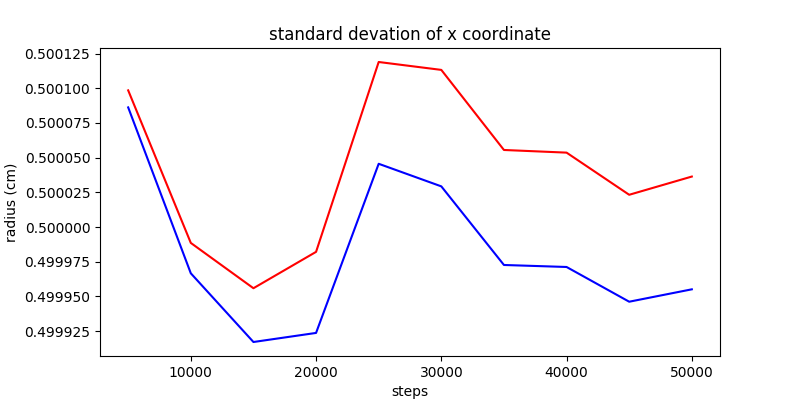

In [15]:
emitted_radius, ax1 = plt.subplots(1, 1, figsize=(8, 4))
# exlicitly make ion_profile the active figure:
plt.figure(emitted_radius.number)

ax1.set_title('standard devation of x coordinate')

steps = []
emitted_ion_radius = []
emitted_electron_radius = []
for step in sorted(full.keys()):
    steps.append(step)
    emitted_ion_radius.append(1.e2 * np.std(full[step]['H2+'][:, 0]))
    emitted_electron_radius.append(1.e2 * np.std(full[step]['emitted e-'][:, 0]))

ax1.plot(steps, emitted_ion_radius, 'b')
ax1.plot(steps, emitted_electron_radius, 'r')
ax1.set_xlabel('steps')
ax1.set_ylabel('radius (cm)')
# ion_profile.savefig('emitted_radius.pdf')
plt.show()